In [1]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.table import Table
import seaborn as sns

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots

matplotlib.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = 'white'
#plt.rcParams['legend.handletextpad']=-0.5

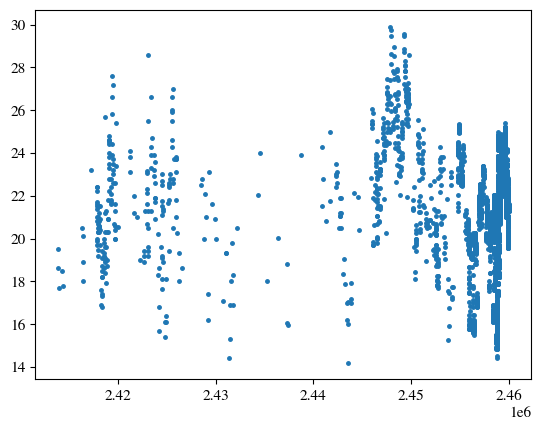

['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band', 'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2', 'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag', 'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation', 'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer', 'Credit']
chi2/dof =  0.8914220626314039


Text(0, 0.5, 'mag, flattened')

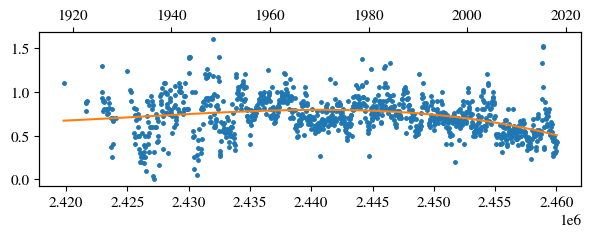

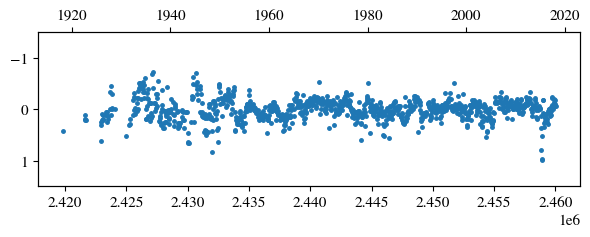

In [2]:
## RVs
rva = Table.read('RVs/BG_rvall.csv')
plt.plot(rva['JD'],rva['RV'],'.')
plt.show()

# Photometry
daavso = Table.read("aavsodata_643217704ea90.txt",format='ascii') # new AAVSO file
# removed a few measurements that had photometry given as <1.6 
daavso.sort('JD')
print(daavso.keys())
daavso['Magnitude']=daavso['Magnitude'].astype(float)

selVisV = (daavso['Band']=='Vis.') | (daavso['Band']=='V') 
selVis  = (daavso['Band']=='Vis.')
selV  = (daavso['Band']=='V')
selJ  = (daavso['Band']=='J')
selH  = (daavso['Band']=='H')
seldate = daavso['JD']<2458000



from astropy.modeling import models, fitting


def get_rolling_means(t,rv,dt):
    """time (JD), rv (km/s), dt (days)"""

    bins = np.linspace(t[0],t[-1],int(np.ceil((t[-1]-t[0])/dt)) )
    xpm = (bins[1:]+bins[:-1])/2
    ypm = np.zeros_like(xpm)
    epm = np.zeros_like(xpm)

    for i in range(len(bins)-1):
        sel = (t >= bins[i]) & (t < bins[i+1])
        #print(bins[i],bins[i+1],len(rv[sel]), np.nanmean(rv[sel]), np.sqrt( np.var(rv[sel]) ) )
        ypm[i] = np.nanmean(rv[sel])
        epm[i] = np.sqrt( np.var(rv[sel]) )

    sel = np.isfinite(ypm)
    return xpm[sel],ypm[sel],epm[sel]

# 12 = 1 month rolling means
npyr =12
#seldate2 = (daavso['JD']>Time(1950,format='jyear').jd ) & (daavso['JD']<Time(1990,format='jyear').jd )
mysel = selVis  #& seldate #selVis & seldate
_t,_mag,_emag = get_rolling_means(daavso[mysel]['JD'],daavso[mysel]['Magnitude'],365.25/npyr)
aavsoT = Table([_t,_mag,_emag],names=['JD','mag','mag_err'])


fig,ax = plt.subplots(figsize=(7,2))
ax.plot(aavsoT['JD'],aavsoT['mag'],'.')

ayr = ax.twiny()
ayr.set_xlim(Time(aavsoT['JD'][0],format='jd').jyear, Time(aavsoT['JD'][-1],format='jd').jyear)



m_init = models.Polynomial1D(3)
fit_m = fitting.LevMarLSQFitter()
m = fit_m(m_init, aavsoT['JD'],aavsoT['mag'] )

ax.plot(aavsoT['JD'],m(aavsoT['JD']) )

print('chi2/dof = ',np.sum(  (aavsoT['mag']-m(aavsoT['JD']))**2 )  / np.std(aavsoT['mag'])**2  / (len(aavsoT)-len(m_init.parameters)))\


aavsoT['mag_flat'] = aavsoT['mag']-m(aavsoT['JD'])

fig,ax = plt.subplots(figsize=(7,2))
ax.plot(aavsoT['JD'],aavsoT['mag_flat'],'.')
ax.set_ylim(1.5,-1.5)

ayr = ax.twiny()
ayr.set_xlim(Time(aavsoT['JD'][0],format='jd').jyear, Time(aavsoT['JD'][-1],format='jd').jyear)
plt.ylabel('mag, flattened')

# Summary Figure

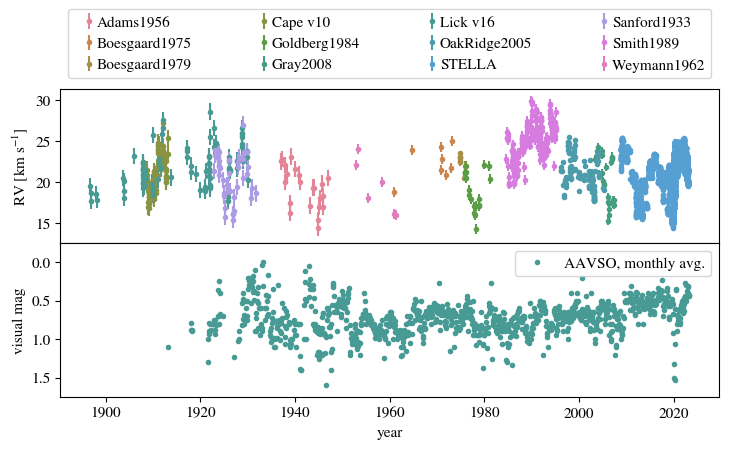

In [3]:
fig,axs = plt.subplots(figsize=(8.5,4),nrows=2,ncols=1,sharex=True)

colors=sns.color_palette("husl",n_colors=len(np.unique(rva['source'])),desat=0.7 )
for i,source in enumerate(np.unique(rva['source'])):
    sel = rva['source']==source
    axs[0].errorbar(Time(rva['JD'][sel],format='jd').jyear,rva['RV'][sel],rva['RV_err'][sel],
                 label=source,marker='o',linestyle='',color=colors[i],markersize=3,rasterized=True)
axs[0].legend(bbox_to_anchor=(0, 1.02,1,0.2),loc='lower left',mode='expand',ncols=4,handletextpad=-0.5)
axs[0].set_ylabel('RV [km s$^{-1}$]')

axs[1].plot(Time(aavsoT['JD'],format='jd').jyear,aavsoT['mag'],
                marker='o',linestyle='',markersize=3,label='AAVSO, monthly avg.',color=colors[6],rasterized=True)
axs[1].legend(loc='upper right')
axs[1].set_ylim(1.75,-0.25)
axs[1].set_ylabel('visual mag')
axs[1].set_xlabel('year')

plt.subplots_adjust(hspace=0)

plt.savefig("figs/rv_aavso_summary.pdf",bbox_inches='tight',dpi=300)

# Periodogram

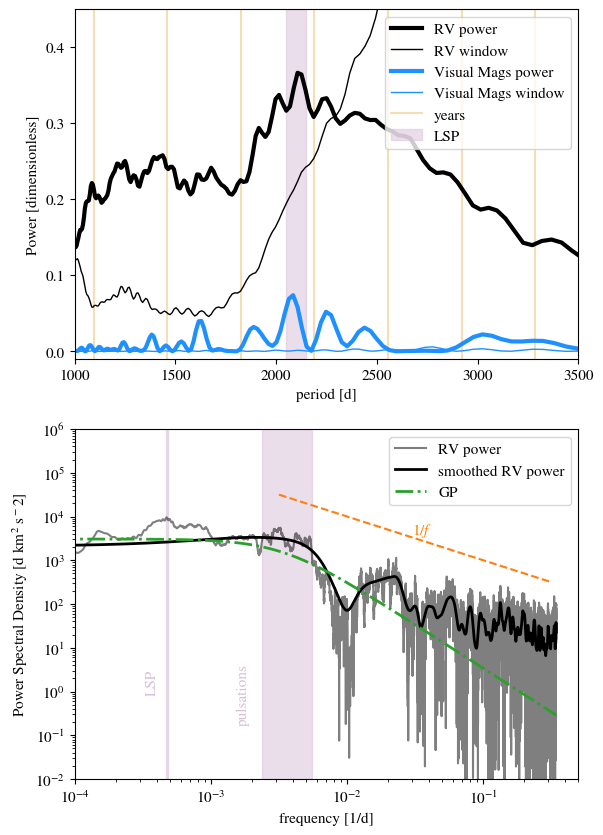

In [29]:
from astropy.timeseries import LombScargle


window_fr, window = LombScargle(rva['JD'], np.ones_like(rva['RV'])).autopower()
fr, power = LombScargle(rva['JD'], rva['RV']).autopower()
a_fr, a_pow = LombScargle(aavsoT['JD'],aavsoT['mag']).autopower()
a_wfr,a_wpow = LombScargle(aavsoT['JD'],np.ones_like(aavsoT['mag'])).autopower()


plt.figure(figsize=(6.5,10))
plt.subplot(211)
plt.plot(1/fr,power,label='RV power',ls='-',lw=3,color='k')
plt.plot(1/window_fr,window,label='RV window',lw=1,color='k')
plt.plot(1/a_fr,a_pow,label='Visual Mags power',ls='-',lw=3,color='dodgerblue')
plt.plot(1/a_wfr,a_wpow,label='Visual Mags window',ls='-',lw=1,color='dodgerblue')


for i in range(10):
    plt.axvline(i*365,color='wheat',label=np.where(i==0,'years',''),zorder=0)

#plt.axvline(2110,color='Cyan',ls="--",label='2110 d',zorder=0)
plt.axvspan(2050,2150,alpha=0.5,color='thistle',label='LSP')


#plt.semilogx()
plt.xlim(1000,3500)
plt.ylim(-0.01,0.45)
plt.legend(loc='upper right')
plt.xlabel('period [d]')
plt.ylabel('Power [dimensionless]')




from astropy.convolution import Gaussian1DKernel, convolve

plt.subplot(212)

def Sexp(f,l=3000):
    """ f is in [1/d], ref: p28: https://gpss.cc/gpss21/slides/Heinonen2021.pdf,
     Wolfram Alpha: "Fourier transform exp(- |x|/l)" (normalization 1)  """ 
    return 2*l/(1+(l*f)**2)  #((1/l + l*f**2  ))**-1


rv = Table.read("RVs/BG_rvall.csv")
fr, power = LombScargle(rv["JD"], rv['RV'],normalization='psd').autopower(method='auto')



plt.loglog(fr,power,label='RV power',ls='-',alpha=0.5,color='k')
plt.loglog(fr,convolve(power,Gaussian1DKernel(300)),label='smoothed RV power',ls='-',lw=2,color='k')
plt.xlabel('frequency [1/d]')
plt.ylabel('Power Spectral Density [d km$^2$ s$^-2$]')

xp = np.logspace(-2.5,-0.5,100)
plt.plot(xp,1e2/xp,ls='--',color='C1')

plt.axvspan(1/2150,1/2050,alpha=0.5,color='thistle')
plt.axvspan(1/420,1/180,alpha=0.5,color='thistle')
plt.annotate("LSP",(1/3000,1),rotation=90,color='thistle')
plt.annotate("pulsations",(1/650,0.2),rotation=90,color='thistle')
plt.annotate("$1/f$",(0.03,4e3),color='C1')

plt.plot(fr,2.26**2 * Sexp(fr,l=300),ls='-.',label='GP',lw=2,color='C2')

plt.xlim(1e-4,0.5)
plt.ylim(1e-2,1e6)
plt.legend(loc="upper right")


plt.savefig("figs/power_spec.pdf",bbox_inches='tight',dpi=300)

# RADVEL ANALYSIS

In [30]:
gppost = radvel.posterior.load("BG_radvel_MLE_Exp300.0_rv10_p2000.0_2200.0_e0.6___iter_0.pkl")
gpchains = gppost.chains
gplike = gppost.likelihood
print( len(gpchains) )

vfactor=1e3


print(gplike.N,"data points")


# FOLD TC1
tc1med = gpchains['tc1'].quantile(0.5)
sel_p1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] - gpchains['per1'] - tc1med)
sel_m1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] + gpchains['per1'] - tc1med)


gpchains.loc[:,'tc1_fold'] = gpchains['tc1'].loc[:]
gpchains.loc[sel_p1,'tc1_fold'] = gpchains['tc1'].loc[sel_p1]-gpchains['per1'].loc[sel_p1]
gpchains.loc[sel_m1,'tc1_fold'] = gpchains['tc1'].loc[sel_m1]+gpchains['per1'].loc[sel_m1]


plt.figure(figsize=(5,3))
mybins = np.linspace(2459000,2459032.625+2000, 100)
plt.hist(gpchains['tc1'],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1'][sel_p1],histtype='step',bins=mybins,density=False)
plt.hist(gpchains['tc1'][sel_m1],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1_fold'],histtype='step',bins=mybins,density=False)

plt.show()

# write over tc1
gpchains.tc1.loc[:] = gpchains.tc1_fold.loc[:]
# drop column
gpchains.drop(['tc1_fold'],axis=1)
 
print(np.mean(Time(gpchains['tc1'],format='jd').jyear) )






quants = gpchains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))
        
        
#df_synth = gppost.params.basis.to_synth(gpchains)
labels = 'per1 tc1 logk1 gamma'.split()
#gpchains[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

FileNotFoundError: [Errno 2] No such file or directory: 'BG_radvel_MLE_Exp300.0_rv10_p2000.0_2200.0_e0.6___iter_0.pkl'